In [36]:
import torch
from transformers import (
    BertForMaskedLM, 
    BertTokenizer, 
    pipeline, 
    RobertaTokenizer, 
    BertPreTrainedModel, 
    AdamW,
    RobertaForMaskedLM,
    BertForMultipleChoice,
    BertModel
                         )

from transformers.modeling_outputs import MultipleChoiceModelOutput
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import re
import random
import pandas as pd
torch.cuda.set_device(1)

In [ ]:
# !wget https://olmpics.s3.us-east-2.amazonaws.com/challenge/number_comparison/number_comparison_age_compare_masked_train.jsonl.gz
# !wget https://olmpics.s3.us-east-2.amazonaws.com/challenge/number_comparison/number_comparison_age_compare_masked_dev.jsonl.gz

### Load Data

In [3]:
dataset = load_dataset('json', data_files='number_comparison_age_compare_masked_train.jsonl')
dataset['dev'] = load_dataset('json', data_files='number_comparison_age_compare_masked_dev.jsonl')['train']
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking', do_lower_case=True)


Using custom data configuration default
Reusing dataset json (/home/imandel/.cache/huggingface/datasets/json/default-bd7f79f46783f45f/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514)
Using custom data configuration default
Reusing dataset json (/home/imandel/.cache/huggingface/datasets/json/default-3d9b9f178226216c/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514)


In [103]:
def noLang(ex):
    ex['question']['stem']=' '.join([ex['question']['stem'].split()[i] for i in indices ])
    return ex

dataset['no_lang'] = dataset['dev'].map(noLang)


Loading cached processed dataset at /home/imandel/.cache/huggingface/datasets/json/default-3d9b9f178226216c/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-b5cb872bb22151c2.arrow


### Zero Shot

In [4]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
bert_unmask = pipeline('fill-mask', model='bert-large-uncased-whole-word-masking', device=1)
roberta_unmask = pipeline('fill-mask', model='roberta-large', device=1)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def zero_shot_ages(model, mask, tokenizer):
    results = np.zeros([30,25])
    x_offset = 18
    y_offset = 15
    targets = [tokenizer.tokenize(s)[0] for s in ['older', 'younger']]
    for i in tqdm(range(30)):
        for j in range(25):
            i_age = i + x_offset
            j_age = j + y_offset
            compare = model(f"A {i_age} year old person age is  {mask} than a {j_age} year old person .", targets=targets)
#             print(i_age, j_age, max(compare, key=lambda d: d['score'])['token_str'])
            if 'young' in max(compare, key=lambda d: d['score'])['token_str']:
                results[i,j] = 1
    return results
                
            
            

In [6]:
bert_ages = zero_shot_ages(bert_unmask,'[MASK]', bert_tokenizer)
roberta_ages = zero_shot_ages(roberta_unmask, '<mask>', roberta_tokenizer) 

100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


We see similar results to those presented in the table. Here pixels where 'young' is present in the prediction are colored yellow. 

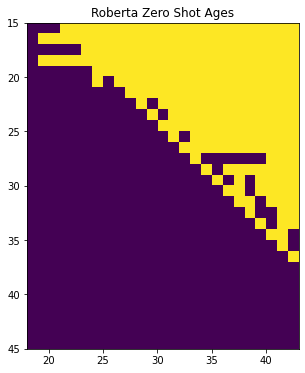

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(roberta_ages, interpolation='none', extent=[18,43,45,15])
ax.set_title('Roberta Zero Shot Ages')
plt.show()

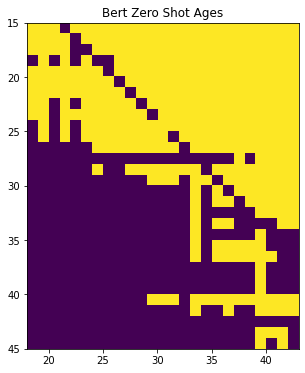

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(bert_ages, interpolation='none', extent=[18,43,45,15])
ax.set_title('Bert Zero Shot Ages')
plt.show()

## MC-MLM

In [24]:
def load_sentences(dataset, batch_size, num_choices, tokenizer):
    labels = torch.zeros([batch_size], dtype=torch.long)[:,None]
    inputs = []
    all_choices = torch.full((batch_size,num_choices), -100)
    for i, sentence in enumerate(dataset):
        if tokenizer.mask_token == '<mask>':
            sentence['question']['stem']= sentence['question']['stem'].replace('[MASK]', '     <mask>')
        inputs.append(sentence['question']['stem'])
        choices_ids = torch.tensor([tokenizer.encode(c['text'], add_special_tokens=False)[0] for c in sentence['question']['choices']])
        all_choices[i,:choices_ids.shape[0]] = choices_ids
        labels[i] = [l['label'] for l in sentence['question']['choices']].index(sentence['answerKey'])

    input_ids = tokenizer(inputs, padding=True, return_tensors="pt").input_ids
    if tokenizer.mask_token == '<mask>':
        mask_idxs = (input_ids==50264).nonzero()[:,1]
    else:
        mask_idxs = (input_ids==103).nonzero()[:,1]
    return input_ids, mask_idxs, labels, all_choices
    

In [25]:
class bertMCMLM(BertForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
#         https://github.com/huggingface/transformers/issues/8907
        for name, param in self.named_parameters():
            if 'predictions' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.cls.predictions.decoder.weight.requires_grad = True
        self.cls.predictions.bias.requires_grad = True
    def forward(
        self,
        input_ids,
        attention_mask=None,
        mask_idxs = None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        all_choices=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        num_choices = all_choices.shape[1] # the num choices will be the same for all in batch
        batch_size = input_ids.size(0)
        logits = torch.zeros(batch_size,num_choices)
        outputs = self.bert(
                    input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    head_mask=head_mask,
                    inputs_embeds=inputs_embeds,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    output_attentions=output_attentions,
                    output_hidden_states=output_hidden_states,
                    return_dict=return_dict,
                )
        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)
        
        outputs = (prediction_scores,) + outputs[2:]        
        if labels is not None:
            masked_lm_loss = 0
            loss_fct = CrossEntropyLoss()  
            for batch_idx, choices in enumerate(all_choices):
                vals = prediction_scores[batch_idx,mask_idxs[batch_idx],[[c] for c in choices]].T
                masked_lm_loss += loss_fct(vals, labels[batch_idx])
                logits[batch_idx] = vals.softmax(dim=1)
            outputs = (logits,) + outputs
            outputs = (masked_lm_loss,) + outputs
        return outputs

In [26]:
class robertaMCMLM(RobertaForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
        for name, param in self.named_parameters():
            if 'lm_head' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.lm_head.decoder.weight.requires_grad = True
        self.lm_head.bias.requires_grad = True
        self.roberta.embeddings.word_embeddings.weight.requires_grad = False
    
    def forward(
        self,
        input_ids,
        attention_mask=None,
        mask_idxs = None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        all_choices=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        num_choices = all_choices.shape[1] # the num choices will be the same for all in batch
        batch_size = input_ids.size(0)
        logits = torch.zeros(batch_size,num_choices)
        outputs = self.roberta(
                    input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    head_mask=head_mask,
                    inputs_embeds=inputs_embeds,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    output_attentions=output_attentions,
                    output_hidden_states=output_hidden_states,
                    return_dict=return_dict,
                )
        sequence_output = outputs[0]
        prediction_scores = self.lm_head(sequence_output)
        
        outputs = (prediction_scores,) + outputs[2:]        
        if labels is not None:
            masked_lm_loss = 0
            loss_fct = CrossEntropyLoss()  
            for batch_idx, choices in enumerate(all_choices):
#                 print(choices)
                vals = prediction_scores[batch_idx,mask_idxs[batch_idx],[[c] for c in choices]].T
                masked_lm_loss += loss_fct(vals, labels[batch_idx])
                logits[batch_idx] = vals.softmax(dim=1)
            outputs = (logits,) + outputs
            outputs = (masked_lm_loss,) + outputs
        return outputs

In [ ]:
evaluate(model, tokenizer)

### Fine-Tuning MLM

In [27]:
def fine_tuneMLM(model, tokenizer, no_examples):
    batch_size = 10
    epochs = 4
    model = model.to('cuda:1')
    model.train()
    optim = AdamW(model.parameters(), lr=5e-5)
    examples = random.sample(list(dataset['train']), no_examples)
    for epoch in range(epochs):
        print(f"starting epoch {epoch}")
        random.shuffle(examples)
        gen = (examples[i:i + batch_size] for i in range(0, len(examples), batch_size))
        for batch in tqdm(gen, total=int(no_examples/batch_size)):
    #     for batch in gen:
            optim.zero_grad()
            input_ids, mask_idxs, labels, all_choices = load_sentences(batch, batch_size, 2, tokenizer)
            input_ids = input_ids.to('cuda:1')
            mask_idxs = mask_idxs.to('cuda:1')
            labels = labels.to('cuda:1')
            all_choices = all_choices.to('cuda:1')
            output = model(input_ids=input_ids, labels=labels, mask_idxs=mask_idxs, all_choices=all_choices)
            loss = output[0]
            loss.backward()
            optim.step() 
#             print(loss)
    return model
    

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking', do_lower_case=True)
model = bertMCMLM.from_pretrained('bert-large-uncased-whole-word-masking')
model = fine_tuneMLM(model, tokenizer, 500)

In [34]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)
model = robertaMCMLM.from_pretrained('roberta-large')
model.train()
model = fine_tuneMLM(model, tokenizer, 0)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


### Evaluating MLM

In [28]:
def evaluateMLM(model, tokenizer, dataset):
    examples = random.sample(list(dataset), 500)
    batch_size = 10
    gen = (examples[i:i + batch_size] for i in range(0, len(examples), batch_size))
    correct = 0
    for batch in tqdm(gen, total=500/batch_size):
        input_ids, mask_idxs, labels, all_choices = load_sentences(batch, batch_size, 2, tokenizer)
        input_ids = input_ids.to('cuda:1')
        mask_idxs = mask_idxs.to('cuda:1')
        labels = labels.to('cuda:1')
        all_choices = all_choices.to('cuda:1')
        output = model(input_ids=input_ids, labels=labels, mask_idxs=mask_idxs, all_choices=all_choices)
        correct += (torch.argmax(output[1], 1) ==labels.T.to('cpu')).sum().item()

    accuracy = correct/500 *100
    return accuracy    
    

### Learning Curves

In [71]:
N= [0, 60, 120, 250, 500, 1000, 2000, 4000]
results = pd.DataFrame([], columns=models)
models = ['bert-base-uncased', 'bert-large-uncased', 'bert-large-uncased-whole-word-masking', 'roberta-base', 'roberta-large']
# models = [berts, robertaMCMLM]

for i, n in enumerate(N):
    for modeltype in models:
        if 'roberta' in modeltype:
            tokenizer = RobertaTokenizer.from_pretrained(modeltype, do_lower_case=True)
            model = robertaMCMLM.from_pretrained(modeltype)
        else:
            tokenizer = BertTokenizer.from_pretrained(modeltype, do_lower_case=True)
            model = bertMCMLM.from_pretrained(modeltype)
        model.train()
        model = fine_tuneMLM(model, tokenizer, n)
        model.eval()
        accuracy = evaluateMLM(model, tokenizer, dataset['dev'])
        results.loc[n, modeltype]= accuracy      

Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 14%|█▍        | 7/50.0 [00:00<00:00, 69.09it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:00<00:00, 72.06it/s]


Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  4%|▍         | 2/50.0 [00:00<00:02, 18.30it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:01<00:00, 46.10it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 5/50.0 [00:00<00:00, 45.53it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:01<00:00, 48.92it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 18%|█▊        | 9/50.0 [00:00<00:00, 83.08it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:00<00:00, 88.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 5/50.0 [00:00<00:01, 44.27it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:00<00:00, 50.80it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 50%|█████     | 3/6 [00:00<00:00, 27.30it/s]

starting epoch 0


 50%|█████     | 3/6 [00:00<00:00, 26.23it/s]

starting epoch 1


 50%|█████     | 3/6 [00:00<00:00, 27.89it/s]

starting epoch 2


 50%|█████     | 3/6 [00:00<00:00, 26.73it/s]

starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 26.90it/s]
100%|██████████| 50/50.0 [00:00<00:00, 74.46it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 33%|███▎      | 2/6 [00:00<00:00, 18.55it/s]

starting epoch 0


 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

starting epoch 1


 33%|███▎      | 2/6 [00:00<00:00, 14.96it/s]

starting epoch 2


 33%|███▎      | 2/6 [00:00<00:00, 19.13it/s]

starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
100%|██████████| 50/50.0 [00:00<00:00, 50.11it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 33%|███▎      | 2/6 [00:00<00:00, 15.77it/s]

starting epoch 0


 50%|█████     | 3/6 [00:00<00:00, 20.61it/s]

starting epoch 1


 33%|███▎      | 2/6 [00:00<00:00, 16.09it/s]

starting epoch 2


 33%|███▎      | 2/6 [00:00<00:00, 18.66it/s]

starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 15.74it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.47it/s]
  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 0
starting epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 2
starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 49.32it/s]
100%|██████████| 50/50.0 [00:00<00:00, 87.47it/s]
  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 0
starting epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 2
starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 40.40it/s]
100%|██████████| 50/50.0 [00:00<00:00, 51.93it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 25%|██▌       | 3/12 [00:00<00:00, 27.90it/s]

starting epoch 0


 25%|██▌       | 3/12 [00:00<00:00, 27.48it/s]

starting epoch 1


 25%|██▌       | 3/12 [00:00<00:00, 26.11it/s]

starting epoch 2


 25%|██▌       | 3/12 [00:00<00:00, 28.13it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 26.46it/s]
100%|██████████| 50/50.0 [00:00<00:00, 79.00it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 17%|█▋        | 2/12 [00:00<00:00, 19.51it/s]

starting epoch 0


 17%|█▋        | 2/12 [00:00<00:00, 19.55it/s]

starting epoch 1


 25%|██▌       | 3/12 [00:00<00:00, 21.04it/s]

starting epoch 2


 17%|█▋        | 2/12 [00:00<00:00, 19.81it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 19.56it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.35it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 17%|█▋        | 2/12 [00:00<00:00, 18.40it/s]

starting epoch 0


 17%|█▋        | 2/12 [00:00<00:00, 18.72it/s]

starting epoch 1


 25%|██▌       | 3/12 [00:00<00:00, 20.56it/s]

starting epoch 2


 25%|██▌       | 3/12 [00:00<00:00, 20.58it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 18.97it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.65it/s]
 50%|█████     | 6/12 [00:00<00:00, 57.53it/s]

starting epoch 0


 50%|█████     | 6/12 [00:00<00:00, 58.93it/s]

starting epoch 1


 50%|█████     | 6/12 [00:00<00:00, 51.91it/s]

starting epoch 2


 58%|█████▊    | 7/12 [00:00<00:00, 60.55it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 55.11it/s]
100%|██████████| 50/50.0 [00:00<00:00, 85.93it/s]
 33%|███▎      | 4/12 [00:00<00:00, 33.21it/s]

starting epoch 0


 42%|████▏     | 5/12 [00:00<00:00, 40.51it/s]

starting epoch 1


 42%|████▏     | 5/12 [00:00<00:00, 41.05it/s]

starting epoch 2


 42%|████▏     | 5/12 [00:00<00:00, 40.70it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 40.53it/s]
100%|██████████| 50/50.0 [00:00<00:00, 51.49it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 12%|█▏        | 3/25 [00:00<00:01, 21.67it/s]

starting epoch 0


 12%|█▏        | 3/25 [00:00<00:00, 23.03it/s]

starting epoch 1


 12%|█▏        | 3/25 [00:00<00:00, 26.19it/s]

starting epoch 2


 12%|█▏        | 3/25 [00:00<00:00, 26.83it/s]

starting epoch 3


100%|██████████| 25/25 [00:00<00:00, 26.99it/s]
100%|██████████| 50/50.0 [00:00<00:00, 74.82it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 2/25 [00:00<00:01, 17.68it/s]

starting epoch 0


 12%|█▏        | 3/25 [00:00<00:01, 21.98it/s]

starting epoch 1


 12%|█▏        | 3/25 [00:00<00:01, 21.37it/s]

starting epoch 2


 12%|█▏        | 3/25 [00:00<00:01, 21.64it/s]

starting epoch 3


100%|██████████| 25/25 [00:01<00:00, 19.12it/s]
100%|██████████| 50/50.0 [00:01<00:00, 47.82it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 2/25 [00:00<00:01, 17.12it/s]

starting epoch 0


 12%|█▏        | 3/25 [00:00<00:01, 21.40it/s]

starting epoch 1


 12%|█▏        | 3/25 [00:00<00:01, 20.46it/s]

starting epoch 2


 12%|█▏        | 3/25 [00:00<00:00, 22.14it/s]

starting epoch 3


100%|██████████| 25/25 [00:01<00:00, 20.42it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.93it/s]
 24%|██▍       | 6/25 [00:00<00:00, 57.17it/s]

starting epoch 0


 24%|██▍       | 6/25 [00:00<00:00, 59.52it/s]

starting epoch 1


 24%|██▍       | 6/25 [00:00<00:00, 59.59it/s]

starting epoch 2


 24%|██▍       | 6/25 [00:00<00:00, 59.49it/s]

starting epoch 3


100%|██████████| 25/25 [00:00<00:00, 59.29it/s]
100%|██████████| 50/50.0 [00:00<00:00, 84.71it/s]
 16%|█▌        | 4/25 [00:00<00:00, 27.70it/s]

starting epoch 0


 16%|█▌        | 4/25 [00:00<00:00, 39.93it/s]

starting epoch 1


 20%|██        | 5/25 [00:00<00:00, 40.37it/s]

starting epoch 2


 16%|█▌        | 4/25 [00:00<00:00, 39.96it/s]

starting epoch 3


100%|██████████| 25/25 [00:00<00:00, 39.53it/s]
100%|██████████| 50/50.0 [00:00<00:00, 50.21it/s]
  3%|▎         | 3/100 [00:00<00:03, 27.01it/s]

starting epoch 2


  3%|▎         | 3/100 [00:00<00:03, 27.57it/s]

starting epoch 3


100%|██████████| 100/100 [00:04<00:00, 24.86it/s]
100%|██████████| 50/50.0 [00:00<00:00, 71.55it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 2/100 [00:00<00:05, 17.87it/s]

starting epoch 0


  3%|▎         | 3/100 [00:00<00:04, 21.60it/s]

starting epoch 1


  2%|▏         | 2/100 [00:00<00:05, 19.17it/s]

starting epoch 2


  3%|▎         | 3/100 [00:00<00:04, 19.71it/s]

starting epoch 3


100%|██████████| 100/100 [00:05<00:00, 19.89it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.40it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 2/100 [00:00<00:05, 19.38it/s]

starting epoch 0


  3%|▎         | 3/100 [00:00<00:04, 20.92it/s]

starting epoch 1


  2%|▏         | 2/100 [00:00<00:05, 19.03it/s]

starting epoch 2


  3%|▎         | 3/100 [00:00<00:04, 21.08it/s]

starting epoch 3


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]
100%|██████████| 50/50.0 [00:01<00:00, 46.95it/s]
  6%|▌         | 6/100 [00:00<00:01, 57.83it/s]

starting epoch 0


  6%|▌         | 6/100 [00:00<00:01, 57.07it/s]

starting epoch 1


  6%|▌         | 6/100 [00:00<00:01, 59.73it/s]

starting epoch 2


  4%|▍         | 4/100 [00:00<00:02, 35.46it/s]

starting epoch 3


100%|██████████| 100/100 [00:02<00:00, 45.36it/s]
100%|██████████| 50/50.0 [00:00<00:00, 91.85it/s]
  4%|▍         | 4/100 [00:00<00:02, 33.22it/s]

starting epoch 0


  4%|▍         | 4/100 [00:00<00:02, 39.69it/s]

starting epoch 1


  5%|▌         | 5/100 [00:00<00:02, 40.05it/s]

starting epoch 2


  3%|▎         | 3/100 [00:00<00:03, 24.94it/s]

starting epoch 3


100%|██████████| 100/100 [00:02<00:00, 33.64it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.42it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 3/200 [00:00<00:07, 27.91it/s]

starting epoch 0


  2%|▏         | 3/200 [00:00<00:07, 26.94it/s]

starting epoch 1


  2%|▏         | 3/200 [00:00<00:07, 26.91it/s]

starting epoch 2


  2%|▏         | 3/200 [00:00<00:07, 26.76it/s]

starting epoch 3


100%|██████████| 200/200 [00:07<00:00, 26.54it/s]
100%|██████████| 50/50.0 [00:00<00:00, 77.80it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 2/200 [00:00<00:10, 19.25it/s]

starting epoch 0


  1%|          | 2/200 [00:00<00:10, 18.18it/s]

starting epoch 1


  1%|          | 2/200 [00:00<00:11, 17.29it/s]

starting epoch 2


  1%|          | 2/200 [00:00<00:11, 17.21it/s]

starting epoch 3


100%|██████████| 200/200 [00:10<00:00, 18.92it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.06it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 3/200 [00:00<00:09, 20.41it/s]

starting epoch 0


  2%|▏         | 3/200 [00:00<00:09, 21.64it/s]

starting epoch 1


  1%|          | 2/200 [00:00<00:10, 19.00it/s]

starting epoch 2


  2%|▏         | 3/200 [00:00<00:09, 21.23it/s]

starting epoch 3


100%|██████████| 200/200 [00:10<00:00, 19.26it/s]
100%|██████████| 50/50.0 [00:01<00:00, 47.99it/s]
  2%|▏         | 4/200 [00:00<00:05, 38.30it/s]

starting epoch 0


  4%|▎         | 7/200 [00:00<00:03, 60.63it/s]

starting epoch 1


  2%|▏         | 4/200 [00:00<00:06, 30.66it/s]

starting epoch 2


  3%|▎         | 6/200 [00:00<00:03, 59.00it/s]

starting epoch 3


100%|██████████| 200/200 [00:03<00:00, 53.55it/s]
100%|██████████| 50/50.0 [00:00<00:00, 91.76it/s]
  2%|▏         | 4/200 [00:00<00:05, 38.61it/s]

starting epoch 0


  2%|▎         | 5/200 [00:00<00:04, 40.22it/s]

starting epoch 1


  2%|▏         | 4/200 [00:00<00:04, 39.85it/s]

starting epoch 2


  2%|▏         | 4/200 [00:00<00:04, 39.77it/s]

starting epoch 3


100%|██████████| 200/200 [00:05<00:00, 38.31it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.90it/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 3/400 [00:00<00:13, 29.44it/s]

starting epoch 0


  1%|          | 3/400 [00:00<00:14, 27.97it/s]

starting epoch 1


  1%|          | 3/400 [00:00<00:14, 26.54it/s]

starting epoch 2


  1%|          | 3/400 [00:00<00:14, 27.05it/s]

starting epoch 3


100%|██████████| 400/400 [00:15<00:00, 25.43it/s]
100%|██████████| 50/50.0 [00:00<00:00, 74.12it/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 2/400 [00:00<00:20, 19.08it/s]

starting epoch 0


  0%|          | 2/400 [00:00<00:20, 19.25it/s]

starting epoch 1


  1%|          | 3/400 [00:00<00:18, 21.60it/s]

starting epoch 2


 82%|████████▎ | 330/400 [00:16<00:03, 20.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:>

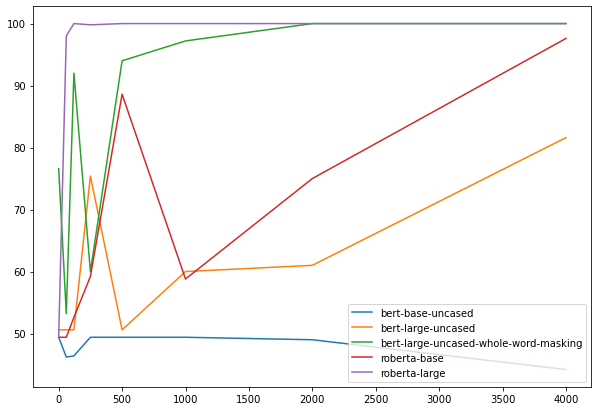

In [105]:
results.plot(figsize=(10,7))

### No Lang

In [131]:
N= [0, 60, 120, 250, 500, 1000, 2000, 4000]

# models = ['bert-large-uncased-whole-word-masking', 'roberta-large']
cols =['bert-large-WWM', 'bert-large-WWM No-Lang', 'roberta-large', 'roberta-large No-Lang']
results = pd.DataFrame([])
for i, n in enumerate(N):
    for modeltype in models:
        if 'roberta' in modeltype:
            tokenizer = RobertaTokenizer.from_pretrained(modeltype, do_lower_case=True)
            model = robertaMCMLM.from_pretrained(modeltype)
        else:
            tokenizer = BertTokenizer.from_pretrained(modeltype, do_lower_case=True)
            model = bertMCMLM.from_pretrained(modeltype)
        model.train()
        model = fine_tuneMLM(model, tokenizer, n)
        model.eval()
        accuracy = evaluateMLM(model, tokenizer, dataset['dev'])
        results.loc[n, modeltype]= accuracy
        accuracy = evaluateMLM(model, tokenizer, dataset['no_lang'])
        results.loc[n, modeltype+' no-lang']= accuracy

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 5/50.0 [00:00<00:00, 47.96it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:01<00:00, 47.69it/s]
100%|██████████| 50/50.0 [00:00<00:00, 56.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 5/50.0 [00:00<00:00, 47.79it/s]

starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3


100%|██████████| 50/50.0 [00:00<00:00, 51.01it/s]
100%|██████████| 50/50.0 [00:00<00:00, 64.44it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 33%|███▎      | 2/6 [00:00<00:00, 19.09it/s]

starting epoch 0


 50%|█████     | 3/6 [00:00<00:00, 20.80it/s]

starting epoch 1


 33%|███▎      | 2/6 [00:00<00:00, 18.87it/s]

starting epoch 2


 50%|█████     | 3/6 [00:00<00:00, 20.72it/s]

starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 20.43it/s]
100%|██████████| 50/50.0 [00:01<00:00, 47.78it/s]
100%|██████████| 50/50.0 [00:00<00:00, 57.51it/s]
  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 0
starting epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

starting epoch 2
starting epoch 3


100%|██████████| 6/6 [00:00<00:00, 40.29it/s]
100%|██████████| 50/50.0 [00:00<00:00, 51.99it/s]
100%|██████████| 50/50.0 [00:00<00:00, 66.38it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 17%|█▋        | 2/12 [00:00<00:00, 19.13it/s]

starting epoch 0


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

starting epoch 1


 17%|█▋        | 2/12 [00:00<00:00, 18.47it/s]

starting epoch 2


 17%|█▋        | 2/12 [00:00<00:00, 19.20it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 20.46it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.43it/s]
100%|██████████| 50/50.0 [00:00<00:00, 57.50it/s]
 42%|████▏     | 5/12 [00:00<00:00, 40.45it/s]

starting epoch 0


 42%|████▏     | 5/12 [00:00<00:00, 41.07it/s]

starting epoch 1


 42%|████▏     | 5/12 [00:00<00:00, 40.62it/s]

starting epoch 2


 42%|████▏     | 5/12 [00:00<00:00, 40.96it/s]

starting epoch 3


100%|██████████| 12/12 [00:00<00:00, 40.59it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.31it/s]
100%|██████████| 50/50.0 [00:00<00:00, 64.08it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 2/25 [00:00<00:01, 18.57it/s]

starting epoch 0


  8%|▊         | 2/25 [00:00<00:01, 18.22it/s]

starting epoch 1


 12%|█▏        | 3/25 [00:00<00:01, 19.41it/s]

starting epoch 2


  8%|▊         | 2/25 [00:00<00:01, 18.43it/s]

starting epoch 3


100%|██████████| 25/25 [00:01<00:00, 15.98it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.48it/s]
100%|██████████| 50/50.0 [00:00<00:00, 56.16it/s]
 16%|█▌        | 4/25 [00:00<00:00, 39.13it/s]

starting epoch 0


 20%|██        | 5/25 [00:00<00:00, 40.58it/s]

starting epoch 1


 20%|██        | 5/25 [00:00<00:00, 40.74it/s]

starting epoch 2


 20%|██        | 5/25 [00:00<00:00, 40.41it/s]

starting epoch 3


100%|██████████| 25/25 [00:00<00:00, 40.22it/s]
100%|██████████| 50/50.0 [00:00<00:00, 50.17it/s]
100%|██████████| 50/50.0 [00:00<00:00, 66.69it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  4%|▍         | 2/50 [00:00<00:02, 16.43it/s]

starting epoch 0


  4%|▍         | 2/50 [00:00<00:02, 19.91it/s]

starting epoch 1


  6%|▌         | 3/50 [00:00<00:02, 20.30it/s]

starting epoch 2


  4%|▍         | 2/50 [00:00<00:02, 19.94it/s]

starting epoch 3


100%|██████████| 50/50 [00:02<00:00, 19.65it/s]
100%|██████████| 50/50.0 [00:01<00:00, 47.44it/s]
100%|██████████| 50/50.0 [00:00<00:00, 56.24it/s]
  8%|▊         | 4/50 [00:00<00:01, 30.01it/s]

starting epoch 0


 10%|█         | 5/50 [00:00<00:01, 40.57it/s]

starting epoch 1


 10%|█         | 5/50 [00:00<00:01, 40.09it/s]

starting epoch 2


  8%|▊         | 4/50 [00:00<00:01, 39.60it/s]

starting epoch 3


100%|██████████| 50/50 [00:01<00:00, 39.20it/s]
100%|██████████| 50/50.0 [00:00<00:00, 50.76it/s]
100%|██████████| 50/50.0 [00:00<00:00, 64.64it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 2/100 [00:00<00:06, 15.40it/s]

starting epoch 0


  2%|▏         | 2/100 [00:00<00:06, 14.65it/s]

starting epoch 1


  2%|▏         | 2/100 [00:00<00:04, 19.73it/s]

starting epoch 2


  2%|▏         | 2/100 [00:00<00:06, 14.09it/s]

starting epoch 3


100%|██████████| 100/100 [00:05<00:00, 19.22it/s]
100%|██████████| 50/50.0 [00:01<00:00, 47.52it/s]
100%|██████████| 50/50.0 [00:00<00:00, 54.15it/s]
  5%|▌         | 5/100 [00:00<00:02, 40.06it/s]

starting epoch 0


  4%|▍         | 4/100 [00:00<00:02, 39.98it/s]

starting epoch 1


  4%|▍         | 4/100 [00:00<00:02, 39.70it/s]

starting epoch 2


  3%|▎         | 3/100 [00:00<00:03, 26.09it/s]

starting epoch 3


100%|██████████| 100/100 [00:02<00:00, 38.29it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.16it/s]
100%|██████████| 50/50.0 [00:00<00:00, 60.50it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 2/200 [00:00<00:10, 19.29it/s]

starting epoch 0


  2%|▏         | 3/200 [00:00<00:09, 21.21it/s]

starting epoch 1


  1%|          | 2/200 [00:00<00:10, 19.27it/s]

starting epoch 2


  2%|▏         | 3/200 [00:00<00:09, 20.44it/s]

starting epoch 3


100%|██████████| 200/200 [00:10<00:00, 19.01it/s]
100%|██████████| 50/50.0 [00:01<00:00, 46.45it/s]
100%|██████████| 50/50.0 [00:00<00:00, 54.35it/s]
  2%|▏         | 4/200 [00:00<00:04, 39.97it/s]

starting epoch 0


  2%|▎         | 5/200 [00:00<00:04, 39.90it/s]

starting epoch 1


  2%|▏         | 4/200 [00:00<00:04, 39.50it/s]

starting epoch 2


  2%|▎         | 5/200 [00:00<00:04, 40.20it/s]

starting epoch 3


100%|██████████| 200/200 [00:05<00:00, 37.90it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.94it/s]
100%|██████████| 50/50.0 [00:00<00:00, 65.61it/s]
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing bertMCMLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing bertMCMLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing bertMCMLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 3/400 [00:00<00:19, 19.93it/s]

starting epoch 0


  0%|          | 2/400 [00:00<00:20, 19.43it/s]

starting epoch 1


  0%|          | 2/400 [00:00<00:20, 19.64it/s]

starting epoch 2


  1%|          | 3/400 [00:00<00:17, 22.62it/s]

starting epoch 3


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]
100%|██████████| 50/50.0 [00:01<00:00, 48.01it/s]
100%|██████████| 50/50.0 [00:00<00:00, 57.38it/s]
  1%|          | 4/400 [00:00<00:11, 35.24it/s]

starting epoch 0


  1%|          | 4/400 [00:00<00:10, 39.52it/s]

starting epoch 1


  1%|          | 4/400 [00:00<00:10, 39.32it/s]

starting epoch 2


  1%|          | 4/400 [00:00<00:10, 39.32it/s]

starting epoch 3


100%|██████████| 400/400 [00:10<00:00, 36.48it/s]
100%|██████████| 50/50.0 [00:01<00:00, 49.67it/s]
100%|██████████| 50/50.0 [00:00<00:00, 64.27it/s]


<AxesSubplot:>

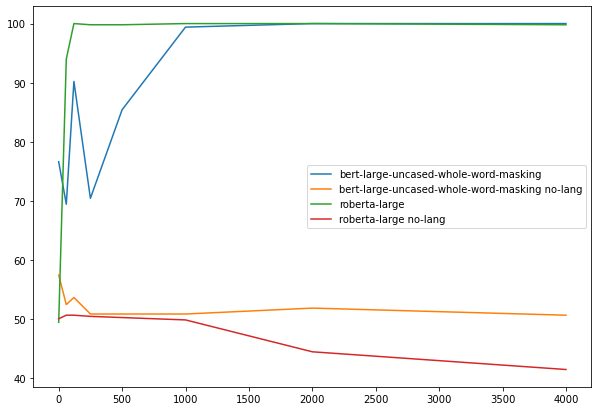

In [134]:
results.plot(figsize=(10,7))

## MC-QA

In [ ]:
def load_qa(dataset, num_choices, tokenizer):
    batch_size=len(dataset)
    sequence_length= tokenizer([[dataset[0]['question']['stem']]*num_choices, [choice['text']for choice in dataset[0]['question']['choices']]], padding=True, return_tensors='pt').input_ids.size(1)
    input_ids = torch.zeros(batch_size, num_choices, sequence_length, dtype=torch.long)
    attention_mask = torch.zeros(batch_size, num_choices, sequence_length, dtype=torch.long)
    token_type_ids = torch.zeros(batch_size, num_choices, sequence_length, dtype=torch.long)
    labels = torch.zeros(batch_size, dtype=torch.long)
    for i, sentence in enumerate(dataset):
        tokens = tokenizer([[sentence['question']['stem']]*num_choices, [choice['text']for choice in sentence['question']['choices']]], padding=True, return_tensors='pt')
        input_ids[i] = tokens.input_ids
        attention_mask[i]= tokens.attention_mask
        token_type_ids[i] = tokens.token_type_ids
        labels[i] = [choice['label'] for choice in sentence['question']['choices']].index(sentence['answerKey'])

    return input_ids, attention_mask, token_type_ids, labels

In [ ]:
# optim = AdamW(model.parameters(), lr=5e-5)
no_examples=10
batch_size=10
examples = random.sample(list(dataset['train']), no_examples)
gen = (examples[i:i + batch_size] for i in range(0, len(examples), batch_size))
input_ids, attention_mask, token_type_ids, labels = load_qa(next(gen),2,tokenizer)
input_ids = input_ids.to('cuda:1')
attention_mask = attention_mask.to('cuda:1')
token_type_ids =token_type_ids.to('cuda:1')
labels = labels.to('cuda:1')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
model = BertForMultipleChoice.from_pretrained('bert-large-uncased-whole-word-masking')

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForMultipleChoice.from_pretrained('bert-base-uncased')

for name, param in model.named_parameters():
    if 'bert.pooler' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
model.classifier.weight.data.normal_(mean=0.0, std=0.02)
model.classifier.bias.data.zero_()
# model.train()
# for param in model.bert.parameters():
#     param.requires_grad = False

In [ ]:
def fine_tune_qa(model, tokenizer, no_examples):
    batch_size = 10
    epochs = 4
    model = model.to('cuda:1')
    model.train()
    optim = AdamW(model.parameters(), lr=1e-5, weight_decay = 0.1)
    examples = random.sample(list(dataset['train']), no_examples)
    for epoch in range(epochs):
        print(f"starting epoch {epoch}")
        random.shuffle(examples)
        gen = (examples[i:i + batch_size] for i in range(0, len(examples), batch_size))
        for batch in gen: #tqdm(gen, total=int(no_examples/batch_size)):
            optim.zero_grad()
            input_ids, attention_mask, token_type_ids, labels = load_qa(batch,2,tokenizer)
            input_ids = input_ids.to('cuda:1')
            attention_mask = attention_mask.to('cuda:1')
            token_type_ids =token_type_ids.to('cuda:1')
            labels = labels.to('cuda:1')
            output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = output.loss
            loss.backward()
            optim.step() 
            print(loss)
    return model

In [ ]:
model.train()
model.to('cuda:1')
optim = AdamW(model.parameters(), lr=1e-5, weight_decay = 0.1)
for i in range(75):
    optim.zero_grad()
    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
    loss = output.loss
    loss.backward()
    optim.step()
    print(loss)

In [ ]:
model = fine_tune_qa(model, tokenizer, 1000)

In [ ]:
def evaluate_qa(model, tokenizer):
    model.eval()
    examples = list(dataset['dev'])#random.sample(list(dataset['dev']), 500)
    random.shuffle(examples)
    batch_size = 10
    gen = (examples[i:i + batch_size] for i in range(0, len(examples), batch_size))
    correct = 0
    for batch in gen:#tqdm(gen, total=500/batch_size):
        input_ids, attention_mask, token_type_ids, labels = load_qa(batch,2,tokenizer)
        input_ids = input_ids.to('cuda:1')
        attention_mask = attention_mask.to('cuda:1')
        token_type_ids =token_type_ids.to('cuda:1')
        labels = labels.to('cuda:1')
        output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        print('guess',torch.argmax(torch.softmax(output.logits, dim=1), dim=1))
        print('label', labels)
        print((torch.argmax(torch.softmax(output.logits, dim=1), dim=1) == labels).sum().item())
    #     print(torch.argmax(torch.softmax(output.logits, dim=1), dim=1)== labels).sum().item()
        correct += (torch.argmax(torch.softmax(output.logits, dim=1), dim=1)== labels).sum().item()

    accuracy = correct/500 *100
    accuracy
    return accuracy  